# Quick usage guide for dsmpy

[dsmpy](https://github.com/afeborgeaud/dsmpy) is a Python package to compute synthetic seismic waveforms for transversely isotropic, spherically symmetric Earth models. It uses [DSM](https://academic.oup.com/gji/article/164/2/411/776381) as Fortran backend.
In this quick tutorial, we'll use [dsmpy](https://github.com/afeborgeaud/dsmpy) to compute synthetic seismic waveforms for the [anisotropic PREM](http://ds.iris.edu/ds/products/emc-prem/), and compare them to those for a model with an ultra low-velocity zone (ULVZ) at the bottom of the Earth's mantle.

In [24]:
# dsmpy can be installed through the conda package manager
# !conda upgrade -c conda-forge -c afeborgeaud --name dsmtmp dsmpy -y

In [17]:
from dsmpy import dsm
from dsmpy.seismicmodel import SeismicModel
from dsmpy.event import Event
from dsmpy.station import Station
from dsmpy.utils.cmtcatalog import read_catalog
from dsmpy.component import Component
from dsmpy.windowmaker import WindowMaker
from dsmpy.modelparameters import ModelParameters, ParameterType
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = ['Helvetica', 'sans-serif']
mpl.rcParams['font.size'] = 12

In [3]:
# download the Global Centroid Moment Tensor catalog (https://www.globalcmt.org/)
catalog = read_catalog()

In [4]:
# get and event from the GCMT catalog
event = Event.event_from_catalog(
    catalog, '201302221201A')

In [5]:
# define an array of seismic stations
# event.longitude+1e-5 is a quick fix to a bug when event.longitude = station.longitude,
# which leads to synthetics with nan values.
stations = [
    Station(
        name=f'{int(d*10):03d}', network='DSM',
        latitude=event.latitude + d, longitude=event.longitude+1e-5)
    for d in np.arange(70, 80, .5)
    ]
stations

[700_DSM,
 705_DSM,
 710_DSM,
 715_DSM,
 720_DSM,
 725_DSM,
 730_DSM,
 735_DSM,
 740_DSM,
 745_DSM,
 750_DSM,
 755_DSM,
 760_DSM,
 765_DSM,
 770_DSM,
 775_DSM,
 780_DSM,
 785_DSM,
 790_DSM,
 795_DSM]

In [6]:
# use the seismic model PREM (http://ds.iris.edu/spud/earthmodel/9991844)
prem = SeismicModel.prem()

In [7]:
# define another model: prem + ulvz
ulvz_thickness = 15.
dvs_percent = -15.
r_ulvz = 3480. + ulvz_thickness

prem_ulvz = SeismicModel.prem()
prem_ulvz = prem_ulvz._add_boundary(r_ulvz)

# index of the zone that contains the ulvz
izone = prem_ulvz.get_zone(3481.)
vsh = prem_ulvz.get_value_at(r_ulvz, ParameterType.VSH)
vsh_ulvz = vsh * (1 + dvs_percent / 100.)

# 3-degree polynomial for the ulvz structure (constant velocity)
poly_ulvz = [vsh_ulvz, 0., 0., 0.]
prem_ulvz.set_value(izone, ParameterType.VSH, poly_ulvz)
print(f'vsh =\n{prem_ulvz._vsh.T}')

vsh =
[[  3.6678      0.         -4.4475      0.       ]
 [  0.          0.          0.          0.       ]
 [  6.1750846   0.          0.          0.       ]
 [  6.9254      1.4672     -2.0834      0.9783   ]
 [ 11.1671    -13.7818     17.4575     -9.2777   ]
 [ 22.3459    -17.2473     -2.0834      0.9783   ]
 [  9.9839     -4.9324      0.          0.       ]
 [ 22.3512    -18.5856      0.          0.       ]
 [  8.9496     -4.4597      0.          0.       ]
 [ -1.0839      5.7176      0.          0.       ]
 [ -1.0839      5.7176      0.          0.       ]
 [  3.9         0.          0.          0.       ]
 [  3.2         0.          0.          0.       ]]


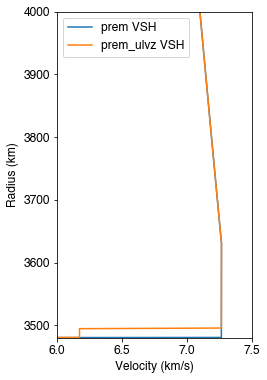

In [8]:
# plot the models
fig, ax = plt.subplots(1, figsize=(3.5, 6))
prem.plot(types=[ParameterType.VSH], ax=ax, label='prem')
prem_ulvz.plot(types=[ParameterType.VSH], ax=ax, label='prem_ulvz')
ax.set_ylim([3480., 4000.])
ax.set_xlim([np.floor(vsh_ulvz), 7.5])
plt.show()

In [9]:
# set the record length, number of points in freqency domain, and time sampling
tlen = 3276.8
nspc = 512
sampling_hz = 20

In [10]:
# inputs for pydsm for prem and prem_ulvz
inputs = [
    dsm.PyDSMInput.input_from_arrays(event, stations, model,
                                     tlen, nspc, sampling_hz)
    for model in [prem, prem_ulvz]
]

In [11]:
# compute the seismic waveforms (done in the frequency domain)
# mode=2 means that only SH is computed (mode=0: SH + PSV, mode=1: PSV)
outputs = [
    dsm.compute(input, mode=2)
    for input in inputs
]

compute SH
compute SH


In [12]:
# transform to the time domain using inverse FFT and apply a low-pass filter
for i in range(len(outputs)):
    outputs[i].to_time_domain()
    outputs[i].filter(freq=0.01, freq2=0.08, type='bandpass')

In [13]:
# compute time windows
windows = WindowMaker.compute(event, stations, 'prem', ['ScS'], [Component.T], t_before=0., t_after=30.)
windows

[201302221201A 700_DSM 1158.15 ScS T,
 201302221201A 705_DSM 1162.13 ScS T,
 201302221201A 710_DSM 1166.11 ScS T,
 201302221201A 715_DSM 1170.10 ScS T,
 201302221201A 720_DSM 1174.09 ScS T,
 201302221201A 725_DSM 1178.10 ScS T,
 201302221201A 730_DSM 1182.11 ScS T,
 201302221201A 735_DSM 1186.13 ScS T,
 201302221201A 740_DSM 1190.15 ScS T,
 201302221201A 745_DSM 1194.18 ScS T,
 201302221201A 750_DSM 1198.22 ScS T,
 201302221201A 755_DSM 1202.27 ScS T,
 201302221201A 760_DSM 1206.32 ScS T,
 201302221201A 765_DSM 1210.38 ScS T,
 201302221201A 770_DSM 1214.44 ScS T,
 201302221201A 775_DSM 1218.51 ScS T,
 201302221201A 780_DSM 1222.59 ScS T,
 201302221201A 785_DSM 1226.67 ScS T,
 201302221201A 790_DSM 1230.75 ScS T,
 201302221201A 795_DSM 1234.85 ScS T]

In [15]:
# use the time windows to cut the synthetics and compute amplitude ratios
icuts = [(window.to_array() * sampling_hz).astype('int')
         for window in windows]

prem_scs = np.array([outputs[0].us[2, i, icut[0]:icut[1]]
 for i, icut in enumerate(icuts)])
prem_ulvz_scs = np.array([outputs[1].us[2, i, icut[0]:icut[1]]
 for i, icut in enumerate(icuts)])

scs_amps = np.vstack([prem_scs.max(axis=1) - prem_scs.min(axis=1),
                      prem_ulvz_scs.max(axis=1) - prem_ulvz_scs.min(axis=1)]).T
amplitude_ratios = scs_amps[:, 1] / scs_amps[:, 0]
print(f'amplitude ratios =\n{amplitude_ratios}')
print(f'avg(amplitude ratios) = {amplitude_ratios[:-2].mean():.2f}')

amplitude ratios =
[ 1.08832743  1.09060453  1.10303692  1.11977464  1.13599135  1.1506044
  1.16163965  1.16285526  1.15276623  1.14169055  1.13932422  1.14189922
  1.13445098  1.08700862  1.04303217  1.04428953  0.99733244  1.00906282
  1.04997964  1.12178889]
avg(amplitude ratios) = 1.11


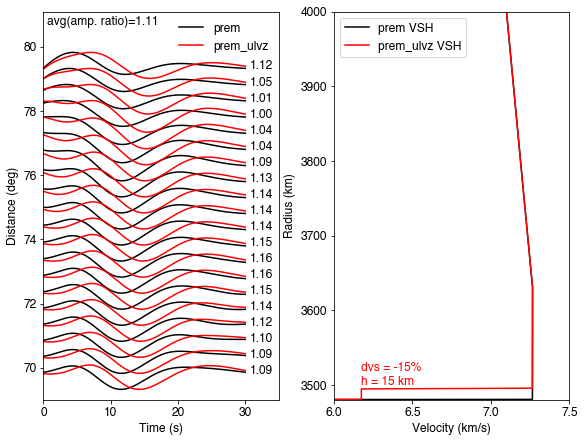

In [19]:
# plot synthetics and models
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 6), constrained_layout=True)

# synthetics (ax0)
outputs[0].plot_component(Component.T, windows, align_zero=True, ax=ax0, color='black')
outputs[1].plot_component(Component.T, windows, align_zero=True, ax=ax0, color='red')
ax0.set_ylim([69, 81.1])
ax0.set_xlim([0, 35])
lines = ax0.get_lines()
ax0.legend([lines[0], lines[-1]], ['prem', 'prem_ulvz'], frameon=False)
for i, ratio in enumerate(amplitude_ratios):
    ax0.text(30.7, 70 + .5*i - 0.2, f'{ratio:.2f}')
ax0.text(0.5, 80.7, f'avg(amp. ratio)={amplitude_ratios[:-2].mean():.2f}')

# models (ax1)
prem.plot(types=[ParameterType.VSH], ax=ax1, label='prem', color='black')
prem_ulvz.plot(types=[ParameterType.VSH], ax=ax1, label='prem_ulvz', color='red')
ax1.set_ylim([3480, 4000.])
ax1.set_xlim([np.floor(vsh_ulvz), 7.5])
ax1.set_xticks([6, 6.5, 7, 7.5])
ax1.text(vsh_ulvz, 3500, f'dvs = {int(dvs_percent)}%\nh = {int(ulvz_thickness)} km', color='red')
fig.savefig('ulvz.pdf', bbox_inches='tight')
plt.show()